<H1>Relationship between IL and price change in a stableswap pool</H1>
Here we investigate the impermanent loss experienced by an LP in a stableswap pool when one of the assets depegs (its value deviates from 1USD). Because the assets in a stableswap pool are expected to remain stable, the pool is optimized to give a better execution price, with less slippage, at the expense of being more vulnerable to impermanent loss in the event of a price change. For the sake of simplicity, the LP both deposits and withdraws a proportional amount of each token (so that these trades don't induce further price changes). Note that the general dynamics and scale of the impermanent loss will hold regardless of which asset the LP chooses to deposit or withdraw.

In [1]:
import sys
import os
import glob
import random
import copy
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.50},
    'USDB': {'usd price': 1, 'weight': 0.50}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=1000,
            trade_fee=0
        )
    },
    agents = {
        'LP': Agent(
            holdings={'USDA': 5000, 'USDB': 5000},
            trade_strategy=invest_all('stableswap')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)


In [5]:
steps = 20000
trade_size_min, trade_size_max = -1000000, 1000000
trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
events = []

for trade_size in trade_sizes:
    # trade to change the price of assets. 
    # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
    events.append(
        run.run(initial_state, time_steps=1, silent=True)[-1].execute_swap(
            pool_id='stableswap',
            agent_id='Trader',
            tkn_sell='USDA' if trade_size > 0 else 'USDB',
            tkn_buy='USDB' if trade_size > 0 else 'USDA',
            sell_quantity=max(abs(trade_size), 0),
        )
    )

usda_prices = [
    1 / event.pools['stableswap'].spot_price
    for event in events
]

for event in events:
    # agent withdraws assets in equal proportion
    StableSwapPoolState.execute_remove_uniform(
        state=event.pools['stableswap'],
        agent=event.agents['LP'],
        shares_removed=event.agents['LP'].holdings['stableswap']
    )

asset_value = [
    value_assets(prices={'USDA': usda_prices[i], 'USDB': 1}, assets=event.agents['LP'].holdings)
    for i, event in enumerate(events)
]

deposit_value = [
    value_assets(prices={'USDA': usda_prices[i], 'USDB': 1}, assets=initial_state.agents['LP'].holdings)
    for i, event in enumerate(events)
]

impermanent_loss = [
    asset_value[i] / deposit_value[i] - 1
    for i, event in enumerate(events)
]

agent_value = [
    value_assets(
        prices={
            'USDA': usda_prices[i]
        }, 
        assets=initial_state.agents['LP'].holdings
    ) - 1
    for i in range(len(events))
]

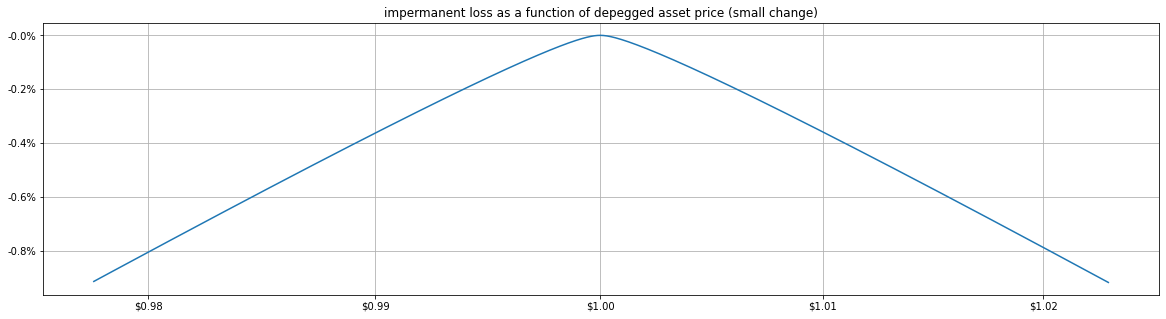

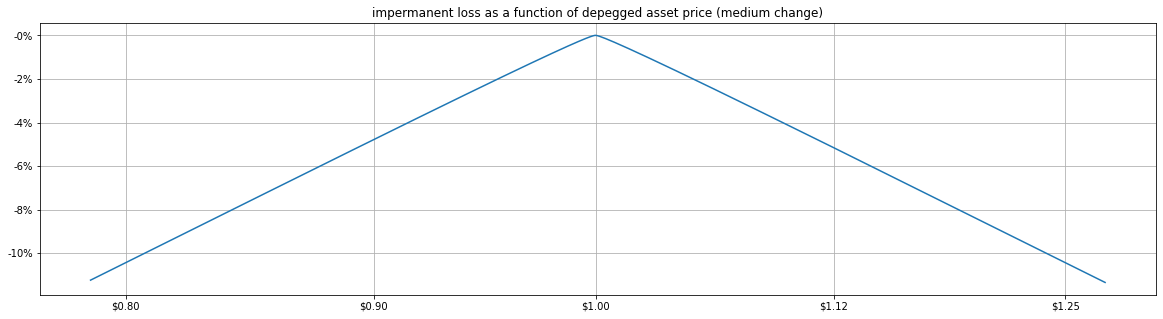

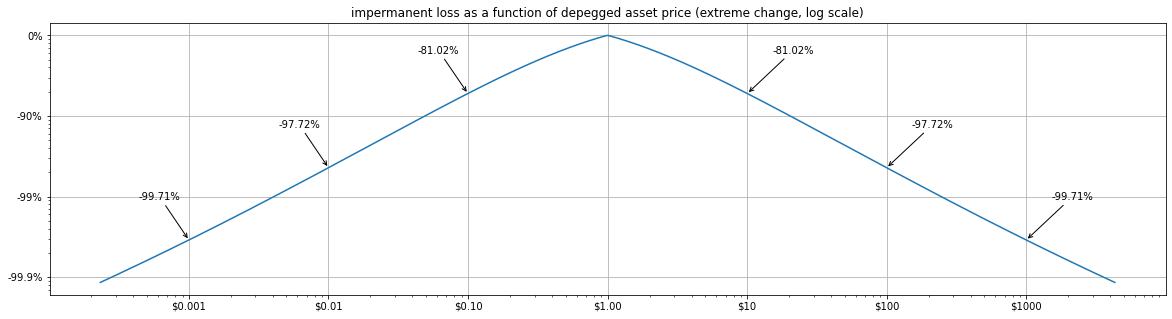

In [13]:
# zoom in
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (small change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.98, 0.99, 1, 1.01, 1.02],
    ['$0.98', '$0.99', '$1.00', '$1.01', '$1.02']
)
plt.yticks(
    [-0.002 * i for i in range(6)],
    [f'-{round(0.2 * i * 10, 2) / 10}%' for i in range(6)]
)
center = usda_prices.index(sorted(usda_prices, key = lambda price: abs(price - 1))[0])
start_range = center - round(len(usda_prices) / 4.41)
end_range = center + round(len(usda_prices) / 4.41)
plt.plot(usda_prices[start_range: end_range], impermanent_loss[start_range: end_range])

# zoom in
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (medium change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.8, 0.9, 1, 1.12, 1.25],
    ['$0.80', '$0.90', '$1.00', '$1.12', '$1.25']
)
plt.yticks(
    [-0.02 * i for i in range(6)],
    [f'-{2 * i}%' for i in range(6)]
)
start_range = center - round(len(usda_prices) / 4.05)
end_range = center + round(len(usda_prices) / 4.05)
plt.plot(usda_prices[start_range: end_range], impermanent_loss[start_range: end_range])

# zoom out
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (extreme change, log scale)')
plt.xscale('log')
plt.grid()
plt.yscale('log')
plt.yticks(
    [1, 0.1, 0.01, 0.001],
    ['0%', '-90%', '-99%', '-99.9%']
)
tick_prices = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.xticks(
    tick_prices,
    ['$0.001', '$0.01', '$0.10', '$1.00', '$10', '$100', '$1000']
)
if 1 in tick_prices:
    tick_prices.remove(1)
for i, price in enumerate(tick_prices):
    best_match = usda_prices.index(sorted(usda_prices, key=lambda x: abs(x - price))[0])
    usda_price = usda_prices[best_match]
    loss = impermanent_loss[best_match]
    plt.annotate(
        text=f'{round(loss * 100, 2)}%',
        xy=(usda_price, 1 + loss),
        xytext=(25, 40) if i > 2 else (-50, 40),
        textcoords='offset points',
        arrowprops={'arrowstyle': '->'}
    )
plt.plot(usda_prices,  [loss + 1 for loss in impermanent_loss])

